In [37]:
%pip install scipy pandas matplotlib numpy

  Using cached matplotlib-3.8.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pillow-10.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.4-cp312-cp312-macosx_11_0_arm64.whl (7.5 MB)
Using cached contourpy-1.2.1-cp312-cp312-macosx_11_0_arm64.whl (245 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.51.0-cp312-cp312-macosx_10_9_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl (64 kB)
Using cached pillow-10.3.0-cp312-cp312-macosx_11_0_arm64.whl (3.4 MB)
Using cached pyparsing-3.1.2-py

# Simulating Geometric Brownian Motion for Bitcoin

The Geometric Brownian Motion (GBM) is a foundational stochastic process used in financial modeling for asset prices.

### Key Properties:
- **Log-Normal Distribution**: Prices in GBM follow a log-normal distribution due to the exponential term in the GBM formula. This means prices are positively skewed, with a lower bound at zero but no upper bound.

- **Drift and Volatility**: **$\mu$** (drift) and **$\sigma$** (volatility) are central to the GBM. The drift reflects the expected return over time, while the  volatility measures the extent of variability or risk associated with the asset's returns.

- **Brownian Motion**: **$W_t$** introduces randomness into the model. It reflects unpredictable changes in the market.

- **Markov Property**: Future prices are conditional on the present price alone, not on the path taken to get there.

- **Continuous Compounding**: Assumes compounding returns.

### Stochastic Differential Equation (SDE):
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$
- $dS_t$: The infinitesimal change in the process $S_t$.
- $\mu$: The drift coefficient, representing the expected return.
- $dt$: A small increment of time.
- $\sigma$: The volatility coefficient, representing the standard deviation of returns.
- $dW_t$: The increment of a Wiener process (Brownian motion).

#### Integrated Form

Upon integrating the SDE, we get the logarithmic form:

$$
\log S_t = \log S_0 + \left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t
$$

This implies that the log of the process follows a normal distribution:

$$
\log S_t \sim \mathcal{N}\left(\log S_0 + \left(\mu - \frac{\sigma^2}{2}\right)t, \sigma^2t\right)
$$

#### Explicit Expression

The explicit solution to the SDE is:

$$
S_t = S_0 e^{\left(\mu-\frac{\sigma^2}{2}\right)t+\sigma W_t}
$$


where:
- **$S_t$**: The value of the stochastic process at time $t$. In the context of financial markets, this is typically the price of an asset at time $t$.

- **$S_0$**: The initial value of the stochastic process, or the price of the asset at time $t = 0$.

- **$e$**: The base of the natural logarithm, used here to exponentiate the drift and diffusion components to ensure that $S_t$ remains positive.

- **$\mu$**: The drift coefficient, representing the expected return of the asset. It is the component that drives the average trend of the asset price over time.

- **$\sigma$**: The volatility coefficient, representing the standard deviation of the asset's returns. This reflects the uncertainty or risk associated with the asset's price changes.

- **$\sigma^2$**: The variance of the asset's returns, which is the square of the volatility. In the exponent, $\mu$ is adjusted by subtracting half of the variance to account for the long-term growth rate of the process.

- **$t$**: The time variable, representing the duration from the initial observation to the current or future point in time.

- **$W_t$**: A realization of the Wiener process (or Brownian motion) at time $t$, which introduces the random fluctuations in the asset's price.

- **$\sigma W_t$**: The random shock to the return, scaled by the asset's volatility. This term captures the unpredictability in the asset's price movements.


#### **$\mu$** (drift) and **$\sigma$** (volatility) in this project:
For this project I used the mean annual return from the last 5 years as **$\mu$** and used Black-Scholes Formula to calculate the implied volatility, using a weighted mean of the call option contract from Deribit.

In [1]:
# Import required libraries
from scipy.stats import norm, ks_2samp
from math import log, sqrt, exp
from scipy.optimize import brentq

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read daily price data
daily_prices = pd.read_csv('daily_price.csv')
daily_prices['Date'] = pd.to_datetime(daily_prices['Date'])
last_date = daily_prices['Date'].iloc[-1]

#### Calculate **$\mu$** (expected annual return). I used the mean annual return from the last 5 years. Data from Yahoo Finance.

In [3]:
# Read annual price data
annual_price_df = pd.read_csv('monthly_price.csv')

# Get year and month from the date
annual_price_df['year'] = annual_price_df['Date'].apply(lambda x: x.split('-')[0])
annual_price_df['month'] = annual_price_df['Date'].apply(lambda x: x.split('-')[1])

# Filter price_df for just the december months (closing year price)
annual_price_df = annual_price_df[annual_price_df['month'] == '12']
annual_price_df = annual_price_df[['Close', 'year']]
annual_price_df

,Close,year
2,320.192993,2014
14,430.566986,2015
26,963.742981,2016
38,14156.400391,2017
50,3742.700439,2018
62,7193.599121,2019
74,29001.720703,2020
86,46306.445313,2021
98,16547.496094,2022
110,42265.187500,2023


In [4]:
# Calculate annual return for each year
annual_price_df['annual_return'] = annual_price_df['Close'] / annual_price_df['Close'].shift(1) - 1

# Calculate the mean annual return of the last 5 years
anual_price_df = annual_price_df.iloc[5:]
anual_price_df.reset_index(drop=True)

,Close,year,annual_return
0,7193.599121,2019,0.922034
1,29001.720703,2020,3.031601
2,46306.445313,2021,0.596679
3,16547.496094,2022,-0.642652
4,42265.187500,2023,1.554174


In [5]:
mean_return = annual_price_df['annual_return'].mean()
print("Mean annual return for the past 5 years: " + str(round(mean_return * 100, 2)) + "%")

Mean annual return for the past 5 years: 222.2%


#### Black-Scholes Formula (calculate the implied volatility **$\mu$**)

##### Wikipedia definition:
>The Black–Scholes /ˌblæk ˈʃoʊlz/[1] or Black–Scholes–Merton model is a mathematical model for the dynamics of a financial market containing derivative investment instruments. 
>From the parabolic partial differential equation in the model, known as the Black–Scholes equation, one can deduce the Black–Scholes formula, which gives a theoretical estimate of the price of European-style options and shows that the option has a unique price given the risk of the security and its expected return (instead replacing the security's expected return with the risk-neutral rate). 
>The equation and model are named after economists Fischer Black and Myron Scholes. 
>Robert C. Merton, who first wrote an academic paper on the subject, is sometimes also credited.


##### Use Black-Scholes to get the implied volatility (sigma) of Bitcoin. 

$$
C = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)
$$



where:
- **$C$** is the call option price.
- **$S_0$** is the current stock (or Bitcoin) price.
- **$K$** is the strike price.
- **$r$** is the risk-free interest rate.
- **$q$** is the dividend yield, which can be considered zero for Bitcoin.
- **$T$** is the time to expiration.
- **$N()$** is the cumulative distribution function of the standard normal distribution.
- **$\sigma$** is the volatility, which we will solve for.
- **$d_1$** and **$d_2$** are calculated as follows:

$$
d_1 = \frac{\log(S_0 / K) + (r - q + \sigma^2/2)T}{\sigma \sqrt{T}}
$$
$$
d_2 = d_1 - \sigma \sqrt{T}
$$





$d1$ and $d2$ are intermediary variables used to calculate the prices of options. This variables are crucial for understanding how several factors affect the value of an option:

- **$d1$** incorporates several elements fo the option and the underlying asset:
    - **$S0$**: Current price of Bitcoin.
    - **$K$**: Strike price of the option (the price at which the option can be exercised).
    - **$r$**: Risk-free interest rate.
    - **$q$**: Dividend yield, which is zero for Bitcoin.
    - **$\sigma$**: Volatility of the underlying asset's price.
    - **$T$**: Time to expiration of the option in years.

- **$d2$** is derived from **$d1$** and is used primarily in determining the probability that the option will be in-the-money (exercising the option would result in a positive payoff) at expiration under a risk-neutral scenario.

In [6]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)

First compute the price of a call option given a volatility. Then to find the implied volatility solve for _sigma_, such that the theoretical call price from Black-Scholes equals the market call price. 

Use Scipy's _brentq_ function to find the root. **Searching between 0.01% and 200% volatility**.

In [7]:
def implied_volatity(S, K, T, r, market_price):
    target = lambda sigma: black_scholes_call(S, K, T, r, sigma) - market_price
    return brentq(target, 0.001, 2)

Current variables (27/04/2024). Derebit trading platform and CoinMarketCap. 

Use options data from Deribit to show how volatility changes with the strike price of the options.

In [8]:
# atm_price = 66000
S0 = daily_prices['Close'].iloc[-1] # current bitcoin price
K = 65000 # strike price
T = 8/12 # (8 months) time to expiration in years.
r = 0.0466 # (4.66%) risk-free rate
dt = 1/365 # time in steps
N = round(T/dt) # number of steps

In [9]:

# Read options data
options_df = pd.read_csv('options.csv')

# Add strke price and option type columns
options_df['strike_price'] = options_df['Instrument'].apply(lambda x: x.split('-')[2]).astype(float)
options_df['option_type'] = options_df['Instrument'].apply(lambda x: x.split('-')[3])

# Filter call options
options_df = options_df[options_df['option_type'] == 'C']

# Calculate implied volatility for every strike price
options_df['implied_volatility'] = options_df.apply(lambda x: implied_volatity(S0, x['strike_price'], T, r, x['Mark'] * S0), axis=1)

# Display the results
options_df[['strike_price', 'Mark', 'Size', 'implied_volatility']]

,strike_price,Mark,Size,implied_volatility
0,10000.0,0.8507,2.3,1.187194
2,15000.0,0.7758,2,0.991403
4,20000.0,0.7030,1.7,0.896018
6,25000.0,0.6324,1.6,0.832910
8,28000.0,0.5910,1.4,0.799811
...,...,...,...,...
114,160000.0,0.0318,0.7,0.762077
116,180000.0,0.0238,0.5,0.776454
118,200000.0,0.0179,8.8,0.786194
120,240000.0,0.0127,4.9,0.825437


Plot volatility smile of the call options

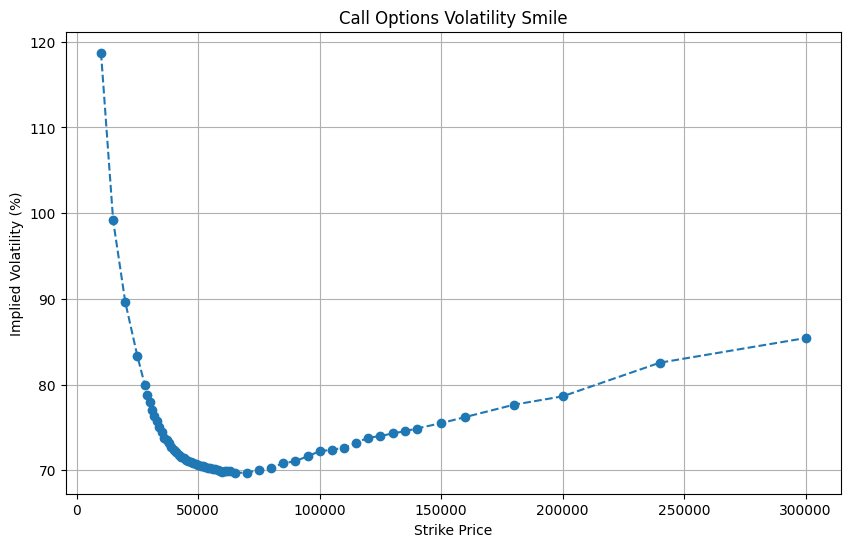

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(options_df['strike_price'], options_df['implied_volatility'] * 100, 'o--')
plt.title('Call Options Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility (%)')
plt.grid(True)
plt.show()

We will use a weighted mean to calculate the implied volatility based on the volumne of the call options.

In [11]:
options_df[options_df['Volume'] == '-'] = np.nan
options_df['Volume'] = options_df['Volume'].astype(float)

# Calculate the mean implied volatility 
iv = (options_df['implied_volatility'] * options_df['Volume']).sum() / options_df['Volume'].sum()
print("Implied volatility: " + str(iv * 100) + "%")

Implied volatility: 76.70506833730988%


### Simulating Geometric Bronian Motion (GBM) for Bitcoin

In [12]:
def brownian_motion(simulations, sigma, mu, T, S0):
    all_simulations = np.zeros((N, simulations))
    for i in range(simulations):
        # Brownian motion increments
        dW = np.random.normal(scale=np.sqrt(dt), size=N)

        # Cumulative sum for the Wiener process
        W = np.cumsum(dW)
        steps = np.linspace(dt, T, N)

        S = S0 * np.exp((mu - 0.5 * sigma ** 2) * steps + sigma * W)

        # Store the simulation result
        all_simulations[:, i] = S
    return all_simulations

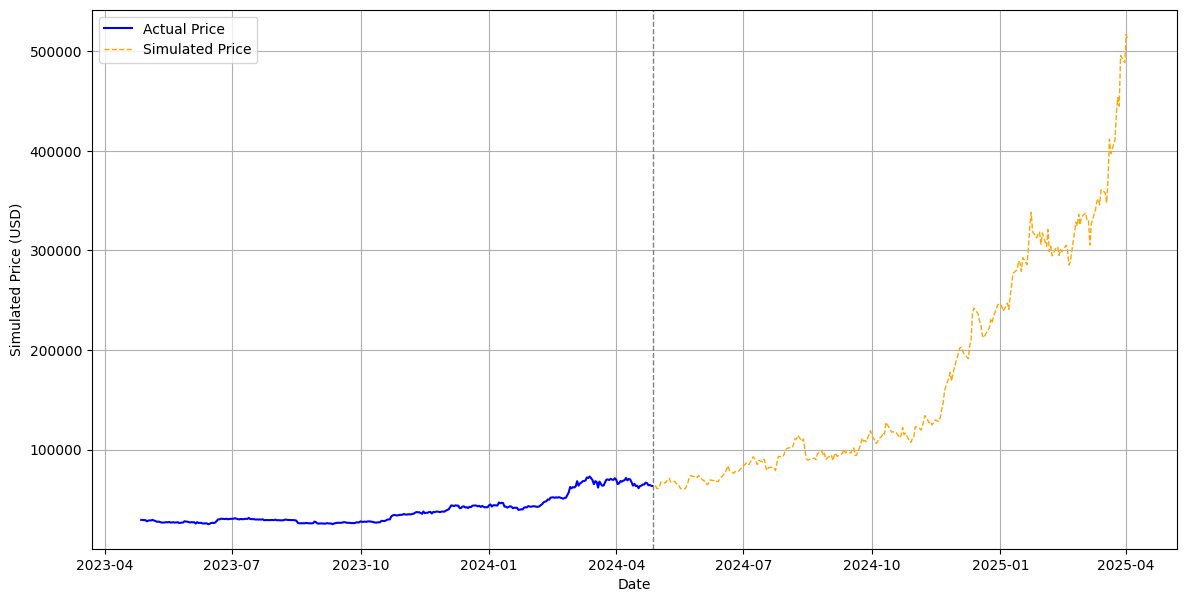

In [14]:
mu = mean_return # Use the 5 year mean return as the drift
sigma = iv # Use the implied volatility as the volatility
simulations = 1 # number of simulations

all_simulations = brownian_motion(simulations, sigma, mu, T, S0)
simulation_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N, freq='B')

# Plot the actual price and the simulations
plt.figure(figsize=(14, 7))
plt.plot(daily_prices['Date'], daily_prices['Close'], label='Actual Price', color='blue')

for i in range(simulations):
    plt.plot(simulation_dates, all_simulations[:, i], label='Simulated Price', color='orange', linestyle='--', lw=1)

plt.xlabel('Date')
plt.ylabel('Simulated Price (USD)')
plt.legend()
plt.grid(True)

plt.axvline(x=last_date, color='grey', linestyle= '--', linewidth=1)
plt.show()


#### Calculate more simulations:

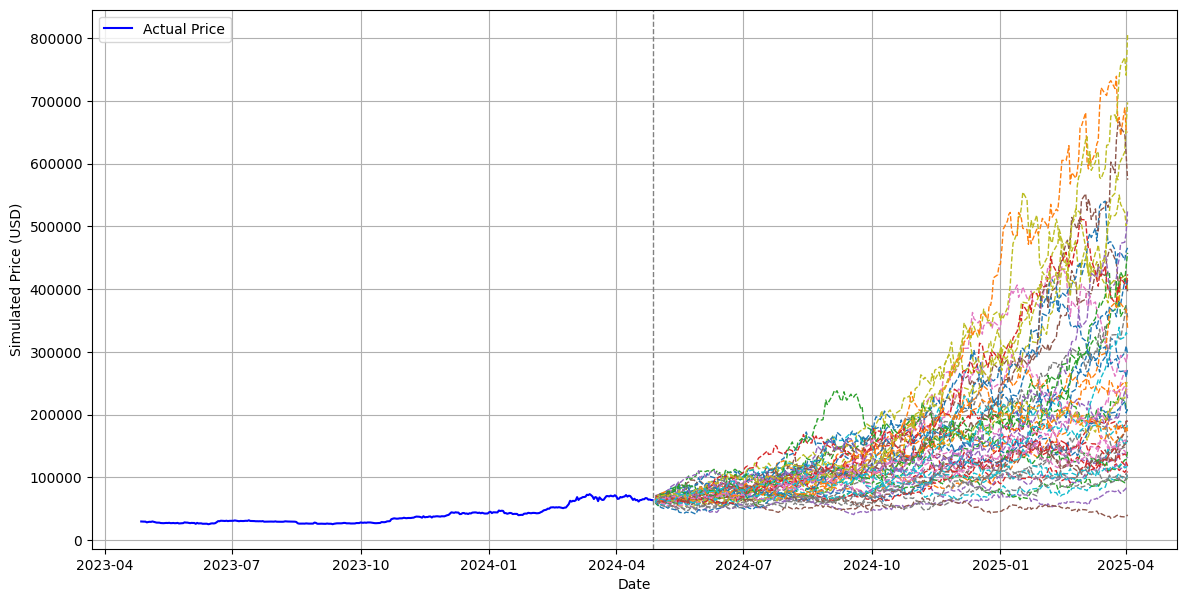

In [16]:
mu = mean_return # Use the 5 year mean return as the drift
sigma = iv # Use the implied volatility as the volatility
simulations = 50 # number of simulations

all_simulations = brownian_motion(simulations, sigma, mu, T, S0)
simulation_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=N, freq='B')

# Plot the actual price and the simulations
plt.figure(figsize=(14, 7))
plt.plot(daily_prices['Date'], daily_prices['Close'], label='Actual Price', color='blue')

for i in range(simulations):
    plt.plot(simulation_dates, all_simulations[:, i], linestyle='--', lw=1)

plt.xlabel('Date')
plt.ylabel('Simulated Price (USD)')
plt.legend()
plt.grid(True)

plt.axvline(x=last_date, color='grey', linestyle= '--', linewidth=1)
plt.show()

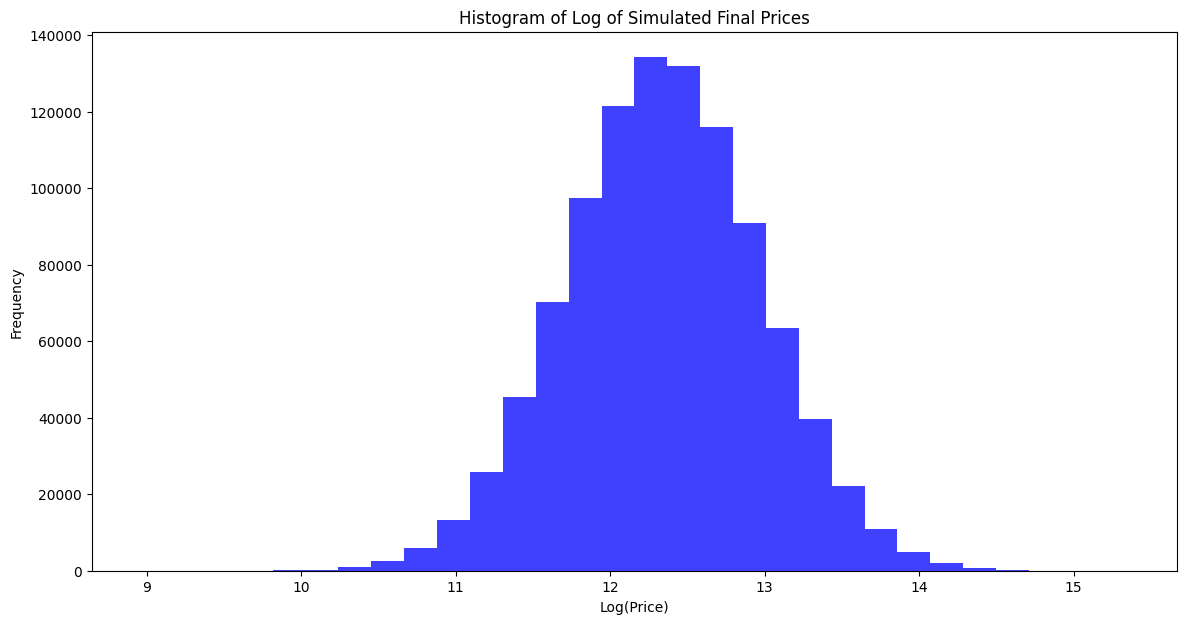

In [17]:
large_simulation = brownian_motion(1000000, sigma, mu, T, S0)
final_prices = large_simulation[-1, :]

plt.figure(figsize=(14, 7))
plt.hist(np.log(final_prices), bins=30, alpha=0.75, color='blue')
plt.title('Histogram of Log of Simulated Final Prices')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

### Quadratic Variation

For a Wiener process, the quadratic variation over a time interval `[0, T]` should be equal to `T`. It's calculated by summing the squares of the increments of the process.

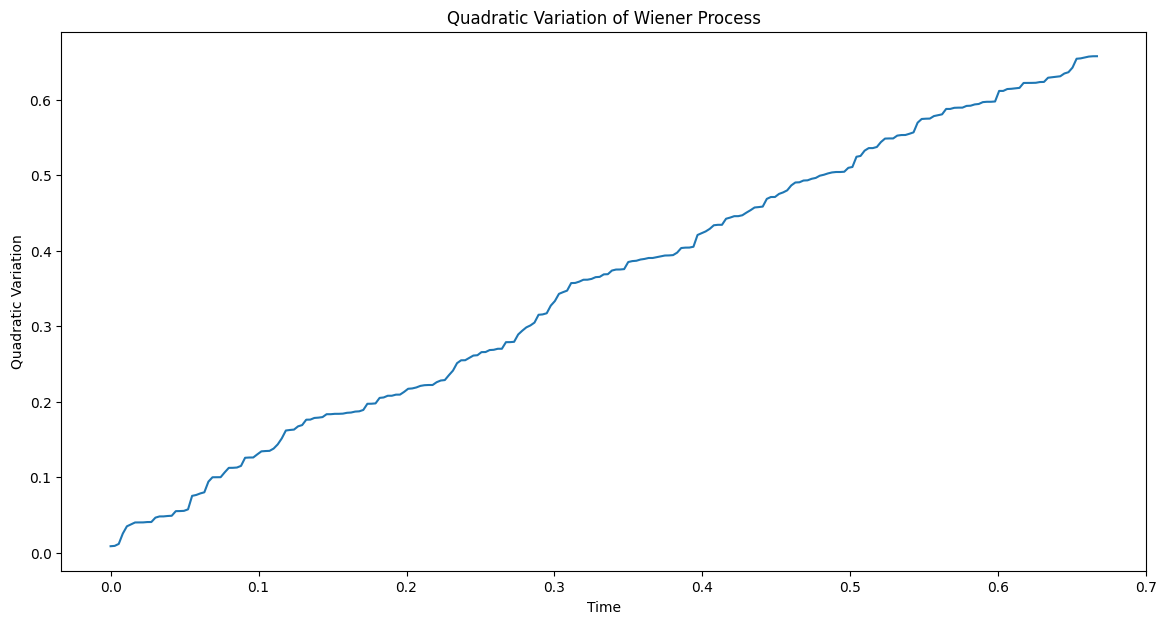

In [18]:
np.random.seed(0)
N = int(T / dt)
dW = np.random.normal(0, np.sqrt(dt), N)
quadratic_variation = np.cumsum(dW**2)

plt.figure(figsize=(14, 7))
plt.plot(np.linspace(0, T, N), quadratic_variation)
plt.xlabel('Time')
plt.ylabel('Quadratic Variation')
plt.title('Quadratic Variation of Wiener Process')
plt.show()

### Markov Property
The conditional probability distribution of the future states of the process depends only on the present state, not on the sequence of events that preceded it.

The future bitcoin price is independent of its past, given its current price.

A stochastic process **${X_t}$** hast he Markov property if for every **$s < t$**, the conditional probability distribution of **$X_t$** given the past values **${X_u : u \leq s}$** depends only on **$X_s$**



$$
P(X_t \leq x | X_s) = P(X_t \leq x | X_s, X_{s-1}, ..., X_0)
$$


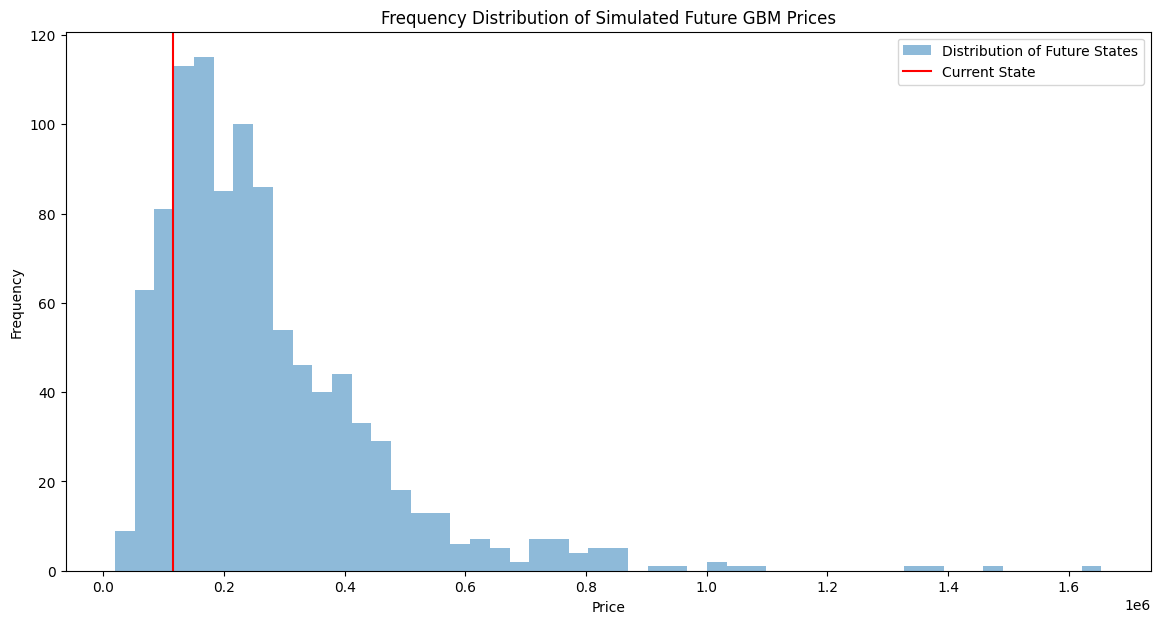

In [21]:
mid_point = T / 2
S_mid = brownian_motion(1, sigma, mu, mid_point, S0)
t_mid = np.linspace(0, mid_point, int(mid_point/dt))

# Freeze the state at mid point
S_current = S_mid[-1]
paths = 1000

# Simulate multiple future paths from the current state
future_states = brownian_motion(paths, sigma, mu, mid_point, S_current)

plt.figure(figsize=(14, 7))
plt.hist(future_states[-1, :], bins=50, alpha=0.5, label="Distribution of Future States")
plt.axvline(S_current, color='red', label="Current State")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.legend()
plt.title("Frequency Distribution of Simulated Future GBM Prices")
plt.show()

### Kolmogorov-Smirnov (KS) Test
To empirically demostrate the Markov property for a Geometric Brownian Motion (GBM), conduct a Kolmogorov-Smirnov test. Nonparametric test that compares two samples to determine if they come from the same distribution.

In [57]:
simulations = 1000
ks_simulations = brownian_motion(simulations, sigma, mu, T, S0)

time_point1 = int(0.25 * len(ks_simulations)) # First quarter
time_point2 = int(0.75 * len(ks_simulations)) # Third quarter

S1 = ks_simulations[time_point1, :]
S2 = ks_simulations[time_point2, :]

future_states_S1 = brownian_motion(simulations, sigma, mu, (T - time_point1) * dt, S1[-1])
future_states_S2 = brownian_motion(simulations, sigma, mu, (T - time_point2) * dt, S2[-1])

ks_statistic, p_value = ks_2samp(future_states_S1[-1, :], future_states_S2[-1, :])

print("Kolmogorov-Smirnov Statistic: " + str(ks_statistic))
print("P-Value: " + str(p_value))

alpha = 0.05

if p_value > alpha:
    print("The two samples come from the same distribuition (fail to reject H0)")
else :
    print("The two samples come from different distributions (reject H0)")

Kolmogorov-Smirnov Statistic: 0.034
P-Value: 0.6101664688189142
The two samples come from the same distribuition (fail to reject H0)
